In [86]:
import unidecode
from nltk.translate.bleu_score import sentence_bleu
import random as rd

play_file_infixes = ['othello', 'antony-and-cleopatra', 'asyoulikeit', 
                     'errors', 'hamlet', 'henryv', 'juliuscaesar', 'lear', 'macbeth', 
                     'merchant', 'msnd', 'muchado', 'richardiii', 'romeojuliet', 
                     'shrew', 'tempest', 'twelfthnight']
#play_file_infixes = ['othello', 'henryv']

agg_original_tuples = []
agg_modern_tuples = []
path = "data/shakespeare/data/align/plays/merged/"

for infix in play_file_infixes:
    modern_tuples = unidecode.unidecode(open(path + infix + "_modern.snt.aligned").read()).split("\n")
    original_tuples = unidecode.unidecode(open(path + infix + "_original.snt.aligned").read()).split("\n")
    agg_original_tuples.extend(original_tuples)
    agg_modern_tuples.extend(modern_tuples)

In [87]:
print("{}\n{}\n".format(agg_original_tuples[0], agg_modern_tuples[0]))
#print("{}\n{}\n".format(agg_original_tuples[5000], agg_modern_tuples[5000]))
# print("{}\n{}\n".format(agg_original_tuples[9000], agg_modern_tuples[9000]))
# print("{}\n{}\n".format(agg_original_tuples[18000], agg_modern_tuples[18000]))


What's the matter, lieutenant?
What's the matter, lieutenant?



In [88]:
# in-class = original = '1'
# raw -> (raw text, label)
import numpy as np

style1_np = np.array(agg_original_tuples)
style1_labels = np.array(['ori' for x in range(len(agg_original_tuples))])
X = np.vstack((style1_np, style1_labels))

style2_np = np.array(agg_modern_tuples)
style2_labels = np.array(['mod' for x in range(len(agg_modern_tuples))])
X2 = np.vstack((style2_np, style2_labels))

X = np.hstack((X,X2))
raw = np.transpose(X)

# idx_col = [str(x) for x in range(len(raw))]
# idx_col = np.array(idx_col).reshape(-1,1)
# print(idx_col.shape)
print(raw.shape)
#raw = np.hstack((idx_col, raw))
raw.shape
raw = np.random.permutation(raw)

(42192, 2)


In [89]:
import pickle

def persist_features(X, name='X_all_plays_1645.pickle'):
    with open(name, 'wb') as f:
        pickle.dump(X, f, pickle.HIGHEST_PROTOCOL)

persist_features(raw, 'raw_all_plays_1645.pickle')

In [91]:
from sklearn.feature_extraction import DictVectorizer
import spacy
import scipy.sparse
nlp = spacy.load('en_core_web_sm')

vectorizer = DictVectorizer()
features = []

#bleu: 0-1, 1 is perfect score
#bleu = sentence_bleu([sen2],sen1)

raw_text_col = 0
LABEL_COL = -1

def extract_punc_feats(txt):
    punc_dict = {}
    punc_data = {'colon':':', 'semicolon': ';', 'lparen':'(',
                'ellipse': '...', 'quote': "'", 'bang': "!"}
    
    for key in punc_data.keys():
        punc_dict[key+'_count'] = txt.count(punc_data[key])
        #         if txt.count(punc_data[key]) != 0:
        #             print(txt)
        
    return punc_dict

def extract_feats(row_idx, raw):
    feature_dict = {}
    pos_dict = {'NOUN_count': 0, 'ADV_count': 0, 'VERB_count': 0, 
                'ADJ_count': 0, 'adv_verb_ratio': 0, 'adj_noun_ratio': 0
               }
    txt = str(raw[row_idx][raw_text_col])
    
    feature_dict['sent_len'] = len(txt)
    
    try:
        doc = nlp(txt)
    except IndexError as e:
        print(e)
        print("offending message [{}], len: {}, row idx: {}".format(txt, len(txt), row_idx))
        doc = []

    pos_sequence = []
    for token in doc:
        pos = token.pos_
        pos_dict[pos+'_count'] = pos_dict.get(pos+'_count', 0) + 1
        if pos == 'NOUN' or pos == 'VERB' or pos == 'CCONJ':
            pos_sequence.append(pos)
            
    pos_sequence = pos_sequence[:7] # shortening the num of features to reasonable
    pos_sequence_name = "_".join(pos_sequence)
    feature_dict[pos_sequence_name] = 1


    if pos_dict['NOUN_count'] == 0 or pos_dict['ADJ_count'] == 0:
        pos_dict['adj_noun_ratio'] = 0
    else:
        pos_dict['adj_noun_ratio'] = pos_dict['NOUN_count'] / pos_dict['ADJ_count'] 

    if pos_dict['VERB_count'] == 0 or pos_dict['ADV_count'] == 0:
        pos_dict['adv_verb_ratio'] = 0
    else:
        pos_dict['adv_verb_ratio'] = pos_dict['VERB_count'] / pos_dict['ADV_count'] 
        
    feature_dict.update(pos_dict)
    feature_dict.update(extract_punc_feats(txt))
    
    if row_idx % 1000 == 0:
        print("{} gold: {} {}\n".format(txt, raw[row_idx][LABEL_COL], feature_dict) )
     
    return feature_dict


for row_idx,_ in enumerate(raw):
    features.append(extract_feats(row_idx, raw))

X = vectorizer.fit_transform(features)
print(X.shape)

X = X.todense()


Let wantons light of heart Tickle the senseless rushes with their heels. gold: ori {'sent_len': 72, 'VERB_NOUN_NOUN_NOUN_VERB_VERB_NOUN': 1, 'NOUN_count': 4, 'ADV_count': 0, 'VERB_count': 3, 'ADJ_count': 2, 'adv_verb_ratio': 0, 'adj_noun_ratio': 2.0, 'ADP_count': 2, 'DET_count': 1, 'PUNCT_count': 1, 'colon_count': 0, 'semicolon_count': 0, 'lparen_count': 0, 'ellipse_count': 0, 'quote_count': 0, 'bang_count': 0}

list index out of range
offending message [], len: 0, row idx: 933
Oh, that I were a fool! gold: ori {'sent_len': 23, 'VERB_NOUN': 1, 'NOUN_count': 1, 'ADV_count': 0, 'VERB_count': 1, 'ADJ_count': 0, 'adv_verb_ratio': 0, 'adj_noun_ratio': 0, 'INTJ_count': 1, 'PUNCT_count': 2, 'ADP_count': 1, 'PRON_count': 1, 'DET_count': 1, 'colon_count': 0, 'semicolon_count': 0, 'lparen_count': 0, 'ellipse_count': 0, 'quote_count': 0, 'bang_count': 1}

What is the news? gold: ori {'sent_len': 17, 'NOUN_VERB_NOUN': 1, 'NOUN_count': 2, 'ADV_count': 0, 'VERB_count': 1, 'ADJ_count': 0, 'adv_verb_r

God rest you merry, sir. gold: ori {'sent_len': 24, 'VERB_NOUN_NOUN': 1, 'NOUN_count': 2, 'ADV_count': 0, 'VERB_count': 1, 'ADJ_count': 0, 'adv_verb_ratio': 0, 'adj_noun_ratio': 0, 'PROPN_count': 1, 'PRON_count': 1, 'PUNCT_count': 2, 'colon_count': 0, 'semicolon_count': 0, 'lparen_count': 0, 'ellipse_count': 0, 'quote_count': 0, 'bang_count': 0}

Eros, can you still see me? gold: mod {'sent_len': 27, 'VERB_VERB': 1, 'NOUN_count': 0, 'ADV_count': 1, 'VERB_count': 2, 'ADJ_count': 0, 'adv_verb_ratio': 2.0, 'adj_noun_ratio': 0, 'INTJ_count': 1, 'PUNCT_count': 2, 'PRON_count': 2, 'colon_count': 0, 'semicolon_count': 0, 'lparen_count': 0, 'ellipse_count': 0, 'quote_count': 0, 'bang_count': 0}

list index out of range
offending message [], len: 0, row idx: 20465
Be wary, then. gold: ori {'sent_len': 14, 'VERB': 1, 'NOUN_count': 0, 'ADV_count': 1, 'VERB_count': 1, 'ADJ_count': 1, 'adv_verb_ratio': 1.0, 'adj_noun_ratio': 0, 'PUNCT_count': 2, 'colon_count': 0, 'semicolon_count': 0, 'lparen_count

As I intend to prosper and repent, So thrive I in my dangerous affairs Of hostile arms! gold: ori {'sent_len': 87, 'VERB_VERB_CCONJ_VERB_VERB_NOUN_NOUN': 1, 'NOUN_count': 2, 'ADV_count': 1, 'VERB_count': 4, 'ADJ_count': 3, 'adv_verb_ratio': 4.0, 'adj_noun_ratio': 0.6666666666666666, 'ADP_count': 3, 'PRON_count': 2, 'PART_count': 1, 'CCONJ_count': 1, 'PUNCT_count': 2, 'colon_count': 0, 'semicolon_count': 0, 'lparen_count': 0, 'ellipse_count': 0, 'quote_count': 0, 'bang_count': 1}

list index out of range
offending message [], len: 0, row idx: 37610
list index out of range
offending message [], len: 0, row idx: 37794
Sir, do you know who I am? gold: mod {'sent_len': 26, 'VERB_VERB_NOUN_VERB': 1, 'NOUN_count': 1, 'ADV_count': 0, 'VERB_count': 3, 'ADJ_count': 0, 'adv_verb_ratio': 0, 'adj_noun_ratio': 0, 'PROPN_count': 1, 'PUNCT_count': 2, 'PRON_count': 2, 'colon_count': 0, 'semicolon_count': 0, 'lparen_count': 0, 'ellipse_count': 0, 'quote_count': 0, 'bang_count': 0}

Even so lies she, Blu

In [92]:

persist_features(X, 'X_all_plays_1645.pickle')

In [93]:
with open('raw_all_plays_1645.pickle', 'rb') as f:
    raw = pickle.load(f)

with open('X_all_plays_1645.pickle', 'rb') as f:
    X = pickle.load(f)
X.shape



(42192, 1645)

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

import time
import math
###############
# training ####
###############


n = len(X)*.25
print(n)
train_val_split_delim = math.floor(n * .8)
val_test_split_delim = math.floor(n * .9)
end_delim = int(n)


print("total rows: {} train val split delim: {} val test split delim: {}".format(len(X), train_val_split_delim, val_test_split_delim))
# numpy note: addressing [:delim] is exclusive of delim, but
#                         [delim:] is inclusive of delim


X_train = X[0:train_val_split_delim]
Y_train = raw[0:train_val_split_delim,LABEL_COL]

X_val = X[train_val_split_delim:val_test_split_delim]
Y_val = raw[train_val_split_delim:val_test_split_delim,LABEL_COL]

X_test = X[val_test_split_delim:end_delim]
Y_test = raw[val_test_split_delim:end_delim,LABEL_COL]

if len(X_test) != len(Y_test):
    raise ValueError("mismatched arrays! {} {}".format(len(preds), len(y_true)))


#mdl = LogisticRegression(random_state=123)
#mdl = MultinomialNB()
mdl = svm.SVC(kernel = 'linear', C=.1) # Accuracy: 0.589743
    # with all plays: .611
mdl.fit(X_train, Y_train)

np.set_printoptions(suppress=True)


10548.0
total rows: 42192 train val split delim: 8438 val test split delim: 9493


In [95]:
# def persist_features(X, name='X_all_plays.pickle'):
#     with open(name, 'wb') as f:
#         pickle.dump(X, f, pickle.HIGHEST_PROTOCOL)

#persist_features(mdl, 'mdl_all_plays_pos_7_gram.pickle')
# persist_features(X, 'X_all_plays_pos_gram.pickle')

In [96]:
# evaluation ###
################
#second class is original


#y_true = raw[train_val_split_delim:val_test_split_delim,LABEL_COL]
preds = mdl.predict(X_val)
#y_true = [int(raw[int(idx)][-1]) for idx in val_indices]

# brier = brier_score_loss(y_true, preds[:,0]) 
# print("brier score:", brier)

#currently slightly worse than randomly permuting preds

def accuracy(preds, y_true):
    if len(preds) != len(y_true):
        raise ValueError("mismatched arrays! {} {}".format(len(preds), len(y_true)))
    num_correct = 0
    for (x,y) in zip(preds, y_true):
        if x == y:
            num_correct = num_correct + 1
    return num_correct/len(preds)

print("Accuracy: {}".format(accuracy(preds,Y_val)))
print("Predictions evaluated: {}".format(len(preds)))

Accuracy: 0.6502369668246446
Predictions evaluated: 1055


[[226 280]
 [ 89 460]]


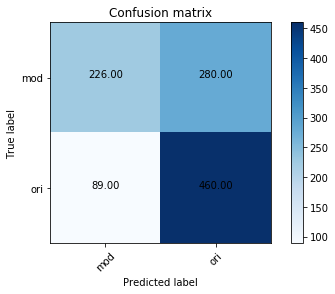

In [97]:
# error analysis ##
##################


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

conf_mat = confusion_matrix(Y_val, preds)
# fig, ax = plt.subplots(figsize=(10,10))
# # sns.heatmap(conf_mat, annot=True, fmt='d',
# #             xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')

# NOTE: this function taken from: 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = 500
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure()
print(conf_mat)
plot_confusion_matrix(conf_mat, classes=mdl.classes_,
                      title="Confusion matrix")
plt.show()

In [98]:
# test_len = len(preds)
# accuracy = sum(preds)/float(test_len)
# print("accuracy: {}".format(accuracy))

#othello accuracy: 0.7428571428571429. but maybe not permuted
#all: accuracy: 0.328237942884228

#pos, no bleu, 2 plays
# Mult NB: .519

In [99]:
# doc = nlp(u"a sleep that ends all the heartache")
# # span = doc[doc[4].left_edge.i : doc[4].right_edge.i+1]
# # span.merge()
# for token in doc:
#     print(token.text, token.pos_, token.dep_, token.head.text)

In [100]:
#raw[:10]

In [101]:
int(2.1)

2

AttributeError: module 'time' has no attribute 'now'